In [1]:
# because of version problems,
# Jupyter notebook prints too many warning messsage
# This parts helps to ignore these warnings
import warnings
warnings.filterwarnings("ignore")

In [2]:
from re import split
from fastai import *
from fastai.vision import *
from fastai.vision.all import *
import torch
import torch.nn as nn
import matplotlib.pyplot as plt
%matplotlib inline

In [3]:
path = Path('/home/qiao/dev/giao/datasets/M300bounding/Step1_training/')

path_img = path/'S_kaggle_wildfire/'
path_label = path/'S_kaggle_wildfire_label/'
# codes = ['Smoke', 'Flame', 'Cloud', 'Background']
codes = ['Smoke', 'Flame', 'Background']

In [4]:
fnames = get_image_files(path_img)
print('======> example of training image', fnames[0])
lbl_names = get_image_files(path_label)
print('======> example of training label', lbl_names[0])

======> example of training image /home/qiao/dev/giao/datasets/M300bounding/Step1_training/S_kaggle_wildfire/000366.jpg
======> example of training label /home/qiao/dev/giao/datasets/M300bounding/Step1_training/S_kaggle_wildfire_label/label_000373.jpg


In [5]:
get_y_fn = lambda x: path_label/f'label_{x.name}'
defaults.use_cuda = True

In [6]:
dls = SegmentationDataLoaders.from_label_func(
    path_img,
    bs = 4,
    fnames = fnames,
    label_func = get_y_fn,
    codes = codes,
    item_tfms = [Resize((385, 480))],
    batch_tfms = [Normalize.from_stats(*imagenet_stats)],
)

In [7]:
name2id = {v:k for k, v in enumerate(codes)}
void_code = name2id['Background']

def acc_smoke(input, target):
    target = target.squeeze(1)
    mask = target != void_code
    return (input.argmax(dim = 1)[mask]==target[mask]).float().mean()

# metrics = acc_smoke

In [8]:
import numpy as np

from sklearn.metrics import f1_score
from sklearn.metrics import average_precision_score
from sklearn.metrics import roc_auc_score

# original, pixel level accuracy
def pixel_accuracy(input, target):
    target = target.squeeze(1)
    mask = target != void_code
    # mask = target
    return (input.argmax(dim = 1)[mask]==target[mask]).float().mean()

# auc: area under the curve, a general computing using the trapezoidal rule.
# roc_curve: Receiver operating characteristic (ROC); xlabel: false positve; ylabel: true positive
# roc_auc_score: area under the receiver operating characteristic curve
def auc_score(input, target):
    target = target.squeeze(1)
    mask = target != void_code
    Auc_score = roc_auc_score(target[mask].cpu(), input.argmax(dim = 1)[mask].cpu(), multi_class='ovr')
    return Auc_score

# f1-score
def f1_score_macro(input, target):
    target = target.squeeze(1)
    mask = target != void_code
    F1 = f1_score(target[mask].cpu(), input.argmax(dim = 1)[mask].cpu(), average = 'macro') # , average = 'macro'
    return F1

# average precision score: area under the precision-recal curve
def precision_score(input, target):
    target = target.squeeze(1)
    mask = target != void_code
    # for multilabel-indicator, `pos_label` is fixed to 1.
    precision_score = average_precision_score(target[mask].cpu(), input.argmax(dim = 1)[mask].cpu())
    return precision_score

# metrics = evaluate_acc
metrics = [pixel_accuracy, auc_score, precision_score, f1_score_macro]
# metrics = roc_curve
# metrics = evaluate_ap

In [9]:
learn = unet_learner(dls, models.resnet34, metrics = metrics,
                    self_attention=True)
device = 'cuda'
learn.model.to(device)

DynamicUnet(
  (layers): ModuleList(
    (0): Sequential(
      (0): Conv2d(3, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
      (1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (2): ReLU(inplace=True)
      (3): MaxPool2d(kernel_size=3, stride=2, padding=1, dilation=1, ceil_mode=False)
      (4): Sequential(
        (0): BasicBlock(
          (conv1): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
          (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
          (relu): ReLU(inplace=True)
          (conv2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
          (bn2): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
        )
        (1): BasicBlock(
          (conv1): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
          (bn1): BatchNorm2d(64, eps=1e-05

SuggestedLRs(valley=6.30957365501672e-05)

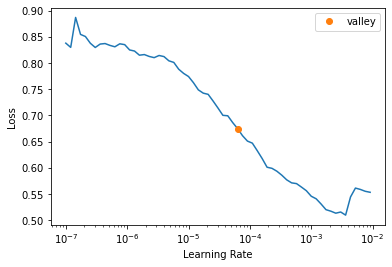

In [10]:
learn.lr_find()

In [11]:
lr = 6.30e-5
learn.fit_one_cycle(18, slice(lr))

epoch,train_loss,valid_loss,pixel_accuracy,auc_score,precision_score,f1_score_macro,time
0,0.315053,0.223342,0.915958,0.856826,0.499640,0.542569,01:53
1,0.179686,0.138692,0.947850,0.860566,0.621666,0.782063,01:52
2,0.157264,0.148427,0.940499,0.914125,0.626285,0.868494,01:52
3,0.133014,0.113018,0.953822,0.864281,0.657016,0.613966,01:51
4,0.106860,0.100907,0.958114,0.893313,0.691711,0.605489,01:51
5,0.105727,0.101834,0.957771,0.867167,0.675782,0.637565,01:52
6,0.091562,0.098182,0.960817,0.873498,0.697950,0.634286,01:51
7,0.086818,0.123032,0.954013,0.825689,0.644119,0.605821,01:51
8,0.084014,0.092469,0.961680,0.929192,0.728161,0.615581,01:51
9,0.078385,0.086920,0.964742,0.911064,0.735103,0.616920,01:51


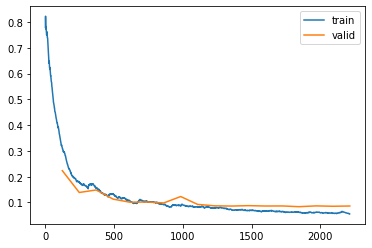

In [12]:
learn.recorder.plot_loss(skip_start=0, with_valid=True)

In [13]:
learn.save('U34freeze_att_step1_20220711')
learn.load('U34freeze_att_step1_20220711')

SuggestedLRs(valley=8.31763736641733e-06)

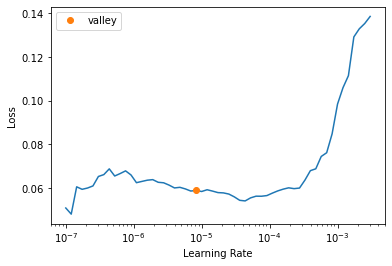

In [15]:
learn.unfreeze()
learn.lr_find()

In [16]:
lr_max = 8.31e-6

In [17]:
learn.fit_one_cycle(6, lr_max)

epoch,train_loss,valid_loss,pixel_accuracy,auc_score,precision_score,f1_score_macro,time
0,0.058730,0.082324,0.966565,0.914609,0.747016,0.620382,01:47
1,0.057425,0.081643,0.966564,0.925668,0.750698,0.621558,01:46
2,0.056219,0.082164,0.966327,0.921010,0.746147,0.620114,01:46
3,0.055803,0.083774,0.966725,0.917646,0.748628,0.620465,01:46
4,0.050863,0.084098,0.966690,0.923734,0.750098,0.621186,01:46
5,0.051292,0.082249,0.967033,0.923425,0.751313,0.621620,01:46


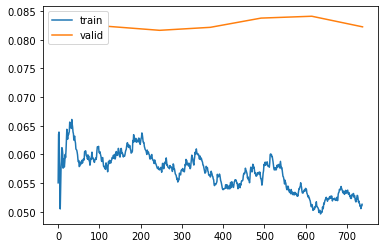

In [18]:
learn.recorder.plot_loss(skip_start=0, with_valid=True)

Path('/home/qiao/dev/giao/datasets/M300bounding/Step1_training/S_kaggle_wildfire/models/u34unfreeze_att_step1_20220711.pth')

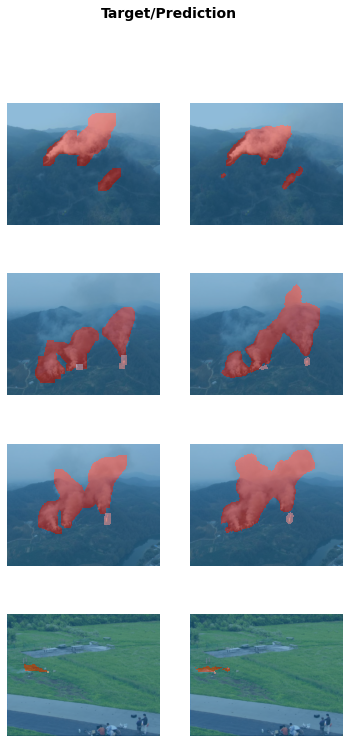

In [19]:
learn.show_results()
learn.save('u34unfreeze_att_step1_20220711')

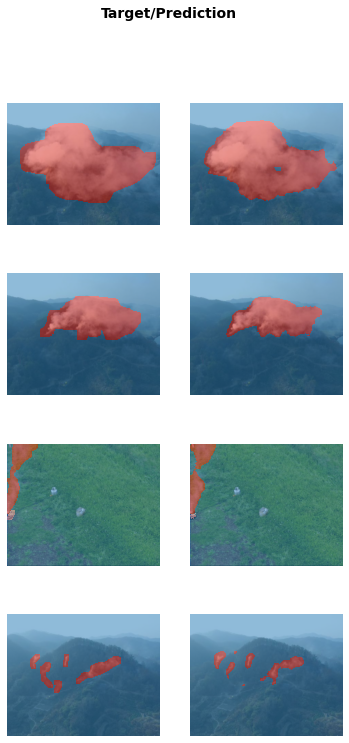

In [20]:
learn.show_results()

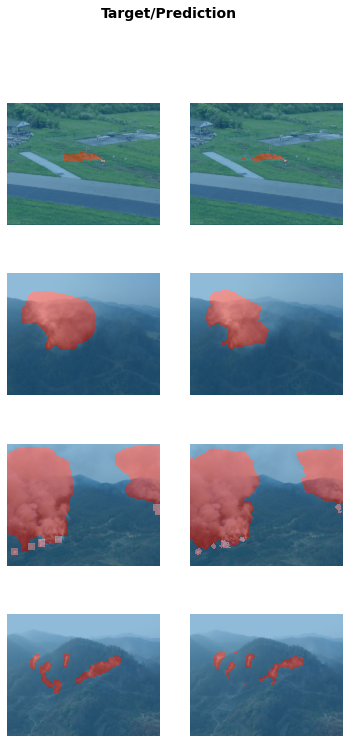

In [21]:
learn.show_results()

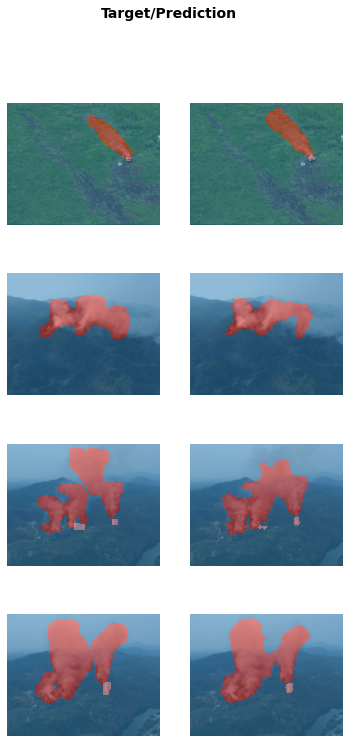

In [22]:
learn.show_results()

In [ ]:
# one time test on untrained distance
import cv2
import numpy as np
from PIL import Image

img = cv2.imread('/home/qiao/dev/giao/datasets/orignial/m300_grabbed_data_1_31.6//rgb/127.png')
# You may need to convert the color.
img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
im_pil = Image.fromarray(img).resize((385, 400))
im_pil.show()
print(im_pil)

In [ ]:
learn.load('u34unfreeze_att_step1_20220711')
# learn.load('attunet')

In [ ]:
# pilimg = PILImage(im_pil)
prediction_mask = learn.predict(img)
seg_map = prediction_mask[0]
torch.Tensor.ndim = property(lambda self: len(self.shape))
plt.imshow(seg_map)

In [ ]:
# test
# testing dependencies
import os
import cv2

from re import split
from fastai import *
from fastai.vision import *
from fastai.vision.all import *
import torch
import torch.nn as nn
import matplotlib.pyplot as plt

from datetime import datetime
import pathlib

%matplotlib inline

In [ ]:
path = Path('/home/qiao/dev/giao/datasets')
path_img = path/'S_kaggle_wildfire/'

path_label = path/'S_kaggle_wildfire_label/'
codes = ['Smoke', 'Flame', 'Void']

In [ ]:
print('======> path_img', path_img)

In [ ]:
fnames = get_image_files(path_img)
print(fnames[0])

lbl_names = get_image_files(path_label)
print(lbl_names[0])

In [ ]:
# connections between images and masks
get_y_fn = lambda x: path_label/f'label_{x.name}'
defaults.use_cuda = False

dls = SegmentationDataLoaders.from_label_func(
    path_img,
    bs = 1,
    fnames = fnames,
    label_func = get_y_fn,
    codes = codes,
    item_tfms = [Resize((400, 400))],
    batch_tfms = [Normalize.from_stats(*imagenet_stats)],
)

In [ ]:
name2id = {v:k for k, v in enumerate(codes)}
void_code = name2id['Void']

def acc_smoke(input, target):
    target = target.squeeze(1)
    mask = target != void_code
    return (input.argmax(dim = 1)[mask]==target[mask]).float().mean()

metrics = acc_smoke

In [ ]:
learn = unet_learner(dls, models.resnet34, metrics = metrics,
                    self_attention=True) # self_attention = False

In [ ]:
learn.load('/home/qiao/dev/giao/datasets/bounding/params/attunet')
# learn.load('attunet')

In [ ]:
# get the test image folder
test_path = '/home/qiao/dev/giao/datasets/m300_grabbed_data_1_17.1/rgb/'
test_fnames = get_image_files(test_path)
total_number = len(test_fnames)
# test whether successfully loaded
print(f'======> example name: {test_fnames[0]}')

In [ ]:
# get the testing time
now = datetime.now()
date_time = now.strftime('%Y%m%d%H%M') # Y for year, m for month, d for day, H for hour, M for minute, S for second
print(f'======> The time: {date_time}')

In [ ]:
# build the folder to store predicted masks
test_pred_path = pathlib.Path(f"/home/qiao/dev/giao/datasets/bounding/pred_{date_time}" )
test_pred_path.mkdir(parents=True, exist_ok=True)

print(f'======> created the folder: {test_pred_path}')

In [ ]:
# process the images one by one with a 'for loop'
from tqdm import tqdm

i = 0
for test_fname in test_fnames:
    # load
    test_pilimgimg = Image.open(test_fname).resize((960, 770))
    test_pilimg = PILImage(test_pilimgimg)

    # predict
    test_pred_torch_all = learn.predict(test_pilimg)
    test_pred_torch= test_pred_torch_all[0]
    plt.imshow(test_pred_torch)
    plt.show()

    # convert
    test_pred_int64 = test_pred_torch.numpy() * 255/2 # torch.int64 --> np.int64
    test_pred_float64 = np.asarray(test_pred_int64, dtype = np.float64, order ='C') # np.int64 --> np.float64
    test_pred_pil = Image.fromarray(test_pred_float64).resize((960, 770)).convert('RGB')
#     test_pred_pil.show()
    # save
    test_pred_pil.save(f'{test_pred_path}/predmask_{test_fname.name}', 'PNG')
    
    # count
    count = []
    i += 1
    count.append(i)
    print(f'======> predicted mask of {test_fname.name} saved! (Counting {count}/{total_number})')
    

print('\n======> Mission accomplished!!!')

In [ ]:
# process the images in smaller size
# get the testing time


now = datetime.now()
date_time = now.strftime('%Y%m%d%H%M') # Y for year, m for month, d for day, H for hour, M for minute, S for second
print(f'======> The time: {date_time}')

# build the folder to store predicted masks


test_pred_path = pathlib.Path(f"/home/qiaolinhan/dev/giao/datasets/bounding/pred_{date_time}" )
test_pred_path.mkdir(parents=True, exist_ok=True)

print(f'======> created the folder: {test_pred_path}')

i = 0
for test_fname in test_fnames:
    # load
    test_pilimgimg = Image.open(test_fname).resize((960, 770))
    test_pilimg = PILImage(test_pilimgimg)

    # predict
    test_pred_torch_all = learn.predict(test_pilimg)
    test_pred_torch= test_pred_torch_all[0]
    plt.imshow(test_pred_torch)
    plt.show()

    # convert
    test_pred_int64 = test_pred_torch[i].numpy() * 255/2 # torch.int64 --> np.int64
    test_pred_float64 = np.asarray(test_pred_int64, dtype = np.float64, order ='C') # np.int64 --> np.float64
    test_pred_pil = Image.fromarray(test_pred_float64).resize((960, 770)).convert('RGB')
#     test_pred_pil.show()
    # save
    test_pred_pil.save(f'{test_pred_path}/predmask_{test_fname.name}', 'PNG')
    
    # count
    count = []
    i += 1
    count.append(i)
    print(f'======> predicted mask of {test_fname.name} saved! (Counting {count}/{total_number})')
    

print('\n======> Mission accomplished!!!')
